In [1]:
import torch
import matplotlib.pyplot as plt
from torch import optim, distributions, nn
from tqdm.notebook import tqdm
import gpzoo
from gpzoo.kernels import MGGP_NSF_RBF
from gpzoo.gp import GaussianPrior, MGGP_SVGP
from gpzoo.likelihoods import PNMF, NSF2, Hybrid_NSF2
from gpzoo.utilities import train_hybrid, train_hybrid_batched, anndata_to_train_val, plot_factors
import squidpy as sq
import numpy as np
from sklearn.decomposition import NMF
import scanpy as sc
import random

from gpzoo.utilities import regularized_nmf, dims_autocorr
from matplotlib.animation import FuncAnimation
from matplotlib import animation
import pickle

/gladstone/engelhardt/home/lchumpitaz/gitclones/GPzoo/gpzoo/utilities.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/nsf/lib/python3.9/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/nsf/lib/python3.9/site-packages/spatialdata/__init__.py:9: UserWarning: Geopandas was set to use PyGEOS, changing to shapely 2.0 with:

	geopandas.options.use_pygeos = True

If you intended to use PyGEOS, set the option to False.
  _check_geopandas_using_shapely()


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
adata = sq.datasets.slideseqv2()
adata = adata.raw.to_adata()

In [4]:
adata.var["mt"] = adata.var_names.str.startswith("mt-")

In [5]:
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

<Axes: >

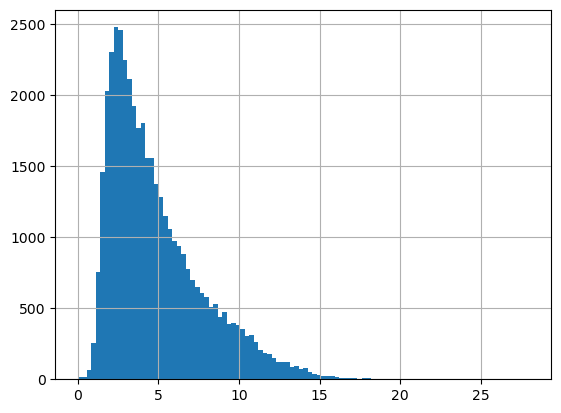

In [6]:
adata.obs.pct_counts_mt.hist(bins=100)

In [7]:
adata = adata[adata.obs.pct_counts_mt < 20] #from 53K to 45K

In [8]:
sc.pp.filter_cells(adata, min_counts=100)

/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/nsf/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_counts'] = number


In [9]:
sc.pp.filter_genes(adata, min_cells=1)

In [10]:
# idx = list(range(adata.shape[0]))
# random.shuffle(idx)
# adata = adata[idx]

In [11]:
Dtr, Dval = anndata_to_train_val(adata, sz="scanpy", train_frac=0.95)

In [12]:
Y = Dtr['Y'].T
Y = Y[~adata.var.MT]

In [13]:
X = Dtr['X']*50.0

/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/nsf/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:956: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


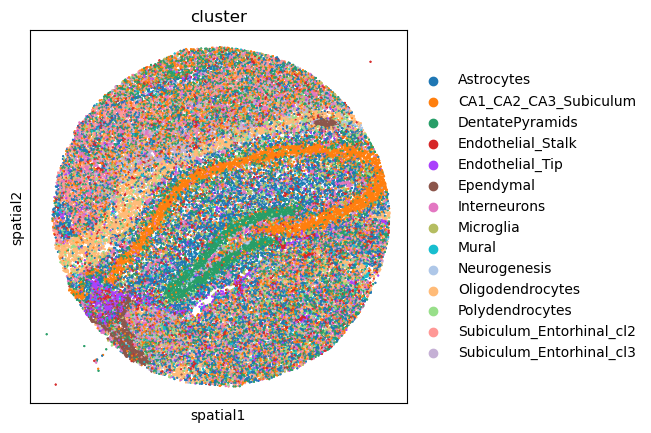

In [14]:
sq.pl.spatial_scatter(adata, color="cluster", size=1, shape=None)


In [15]:
X = torch.tensor(X, dtype=torch.float)
Y = torch.tensor(Y, dtype=torch.float)

In [16]:

L = 20

torch.manual_seed(3)
prior = GaussianPrior(Y, L=L)
pnmf_model = PNMF(prior, Y, L=L)
pnmf_model.to(device)

# model.load_state_dict(torch.load('slideseq_pnmf.pth'))
# with open("slideseq_pnmf_means.pth", "rb") as fp:   
#     means = pickle.load(fp)

# with open("slideseq_pnmf_scales.pth", "rb") as fp:   
#     scales = pickle.load(fp)

PNMF(
  (prior): GaussianPrior()
)

In [17]:
def pnmf_train(model, optimizer, y, device, steps=200, E=20, **kwargs):
    losses = []
    
    means = []
    scales = []
    
    for it in tqdm(range(steps)):
        
        optimizer.zero_grad()
        pY, qF, pF = model.forward(E=E, **kwargs)

        logpY = y*torch.log(pY.rate) - pY.rate

        ELBO = (logpY).mean(axis=0).sum()
        ELBO -= torch.sum(distributions.kl_divergence(qF, pF))

        loss = -ELBO
        loss.backward()
        optimizer.step()

        #keep W and W2 positive after updates
        
        #model.W.data = torch.clamp(model.W.data, min=0.0)

        losses.append(loss.item())
        if (it%10)==0:
            means.append(torch.exp(qF.mean.detach().cpu()).numpy())
            scales.append(qF.scale.detach().cpu().numpy())
    
    with torch.no_grad():
        if device.type=='cuda':
            torch.cuda.empty_cache()
        
    return losses, means, scales

In [18]:
def pnmf_train2(model, optimizer, scheduler, y, device, steps=200, E=20, **kwargs):
    losses = []
    
    means = []
    scales = []
    
    for it in tqdm(range(steps)):
        
        optimizer.zero_grad()
        pY, qF, pF = model.forward(E=E, **kwargs)

        logpY = y*torch.log(pY.rate) - pY.rate

        ELBO = (logpY).mean(axis=0).sum()
        ELBO -= torch.sum(distributions.kl_divergence(qF, pF))

        loss = -ELBO
        loss.backward()
        optimizer.step()
        scheduler.step()

        #keep W and W2 positive after updates
        
        #model.W.data = torch.clamp(model.W.data, min=0.0)

        losses.append(loss.item())
        if (it%10)==0:
            means.append(torch.exp(qF.mean.detach().cpu()).numpy())
            scales.append(qF.scale.detach().cpu().numpy())
    
    with torch.no_grad():
        if device.type=='cuda':
            torch.cuda.empty_cache()
        
    return losses, means, scales

In [19]:
X_train = X.to(device)
Y_train = Y.to(device)

In [20]:
pnmf_model.V.requires_grad=False


In [21]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, pnmf_model.parameters()), lr=1e-3)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=2e-1, steps_per_epoch=5000, epochs=3)

In [22]:
pnmf_model.to(device)


for i in range(3):
    losses, means, scales = pnmf_train2(pnmf_model, optimizer, scheduler, Y_train, device, steps=15000, E=1)

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

ValueError: Tried to step 15001 times. The specified number of total steps is 15000

In [ ]:
plt.plot(losses)

In [29]:
pnmf_model.cpu()

qF, pF= pnmf_model.prior()

factors = torch.softmax(qF.mean, axis=-1).detach().cpu().numpy()
factors_scales = torch.nn.functional.softplus(qF.scale.detach().cpu()).numpy()


In [30]:
moran_idx, moranI = dims_autocorr(factors.T, X)

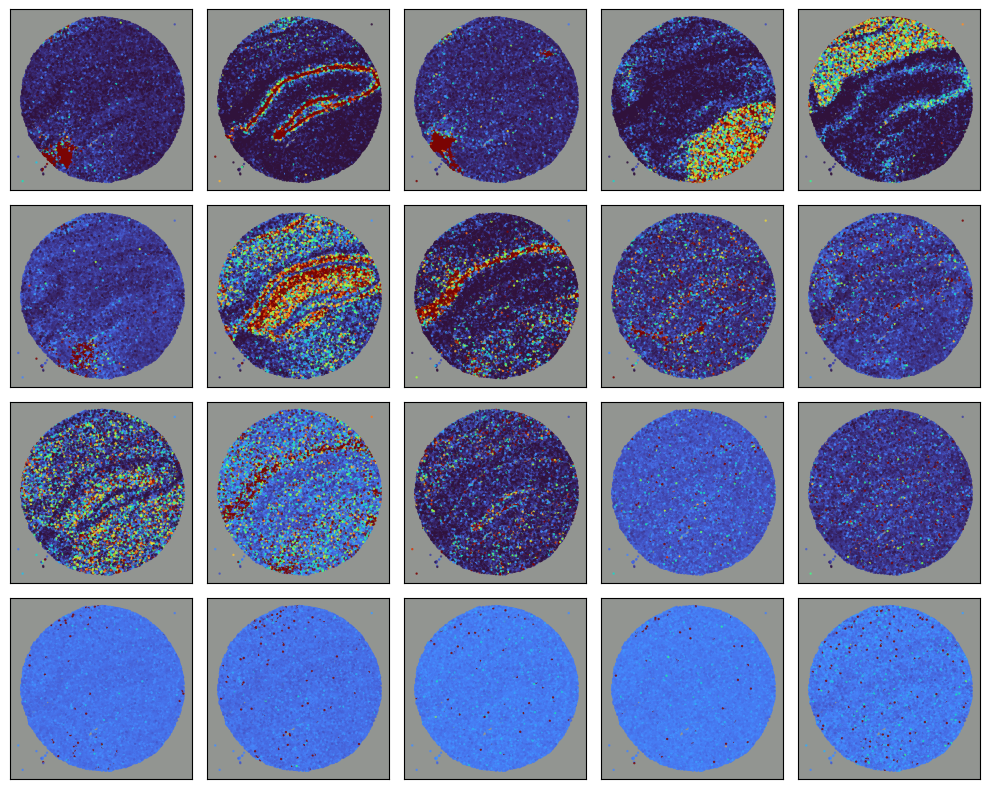

In [31]:
plot_factors(factors, X, moran_idx, size=2, s=0.5)

In [35]:
L = 10
M = 215



groupsX = torch.tensor(adata[Dtr['idx']].obs.cluster.values.codes).type(torch.LongTensor)
n_groups = len(adata.obs.cluster.values.categories)

idx = torch.multinomial(torch.ones(X.shape[0]), num_samples=n_groups*M, replacement=False)



kernel = MGGP_NSF_RBF(L=L, sigma=1.0, lengthscale=1.0, n_groups=n_groups, group_diff_param=1.5)
gp = MGGP_SVGP(kernel, M=M, n_groups=n_groups, jitter=1e-1)

gp.mu = nn.Parameter(pnmf_model.prior.mean[moran_idx][:L, idx].clone())

Lu = torch.eye(n_groups*M).expand(L, n_groups*M, n_groups*M)
Lu_diags = torch.nn.functional.softplus(pnmf_model.prior.scale[moran_idx][:L, idx]).clone()
Lu = Lu_diags[:, :, None]*Lu
gp.Lu = nn.Parameter(Lu.clone())

gp.Z = nn.Parameter(torch.tensor(X[idx]), requires_grad=False)
gp.groupsZ = nn.Parameter(groupsX[idx].type(torch.LongTensor), requires_grad=False)

gaussian_prior = GaussianPrior(Y, L=L)
gaussian_prior.mean = nn.Parameter(pnmf_model.prior.mean[moran_idx][L:, :].clone())
gaussian_prior.scale = nn.Parameter(pnmf_model.prior.scale[moran_idx][L:, :].clone())


model = Hybrid_NSF2(gp, gaussian_prior, Y, L=L, T=L)
model.sf.W = nn.Parameter(pnmf_model.W[:, moran_idx][:, :L].clone())
model.cf.W = nn.Parameter(pnmf_model.W[:, moran_idx][:, L:].clone())


# if not new_model:
#     model.load_state_dict(torch.load('slideseq_mggp_nsf.pth'))
    
#     with open("slideseq_mggp_nsf_means.pth", "rb") as fp:   
#         means = pickle.load(fp)

#     with open("slideseq_mggp_nsf_scales.pth", "rb") as fp:   
#         scales = pickle.load(fp)

#     with open("slideseq_mggp_nsf_idxs.pth", "rb") as fp:   
#         idxs = pickle.load(fp)
        

model.to(device)

/tmp/ipykernel_2758849/3214834482.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp.Z = nn.Parameter(torch.tensor(X[idx]), requires_grad=False)


Hybrid_NSF2(
  (sf): PoissonFactorization(
    (prior): MGGP_SVGP(
      (kernel): MGGP_NSF_RBF()
    )
  )
  (cf): PoissonFactorization(
    (prior): GaussianPrior()
  )
)

In [28]:
def train_batched(model, optimizer, scheduler, X, groupsX, y, device, steps=200, E=20, batch_size=1000, **kwargs):
    losses = []
    
    means = []
    scales = []
    idxs = []
    
    for it in tqdm(range(steps)):
        
        idx = torch.multinomial(torch.ones(X.shape[0]), num_samples=batch_size, replacement=False)
        
        
        optimizer.zero_grad()
        pY, qF1, qU, pU, qF2, pF2 = model.forward_batched(X=X, idx=idx, E=E, groupsX=groupsX[idx], **kwargs)

        logpY = y[:, idx]*torch.log(pY.rate) - pY.rate

        ELBO = (logpY).mean(axis=0).sum()
        ELBO -= torch.sum(distributions.kl_divergence(qU, pU))
        ELBO -= torch.sum(distributions.kl_divergence(qF2, pF2))

        loss = -ELBO
        loss.backward()
        optimizer.step()
        scheduler.step()

        losses.append(loss.item())
        if (it%10)==0:
            idxs.append(idx.detach().cpu().numpy())
            means.append(torch.exp(qF.mean.detach().cpu()).numpy())
            scales.append(qF.scale.detach().cpu().numpy())
    
    with torch.no_grad():
        if device.type=='cuda':
            torch.cuda.empty_cache()
        
    return losses, means, scales, idxs

In [29]:
groupsX_train = groupsX.to(device)

In [30]:
model.sf.prior.kernel.lengthscale.requires_grad = True
model.sf.prior.kernel.sigma.requires_grad = False
model.sf.prior.kernel.group_diff_param.requires_grad = False
model.sf.prior.Z.requires_grad=True
model.sf.prior.mu.requires_grad=True
model.sf.prior.Lu.requires_grad=True
model.V.requires_grad=True

In [31]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=5e-3, steps_per_epoch=1000, epochs=1)

In [ ]:
model.to(device)
losses, means, scales, idxs = train_batched(model, optimizer, scheduler, X_train, groupsX_train, Y_train, device, steps=1000, E=3, batch_size=6000)

  0%|          | 0/1000 [00:00<?, ?it/s]

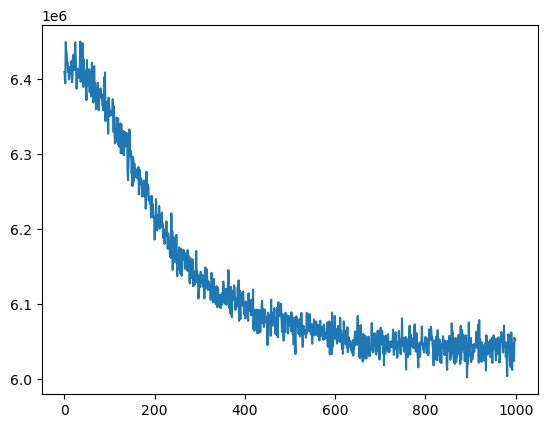

In [34]:
plt.plot(losses)

In [35]:
model.cpu()

qF1, qU, pU = model.sf.prior(X, groupsX=groupsX)
qF2, _ = model.cf.prior()

factors1 = torch.exp(qF1.mean).detach().cpu().numpy()
factors2 = torch.exp(qF2.mean).detach().cpu().numpy()
# factors_scales = torch.nn.functional.softplus(qF.scale.detach().cpu()).numpy()


# del qF, pU, qU

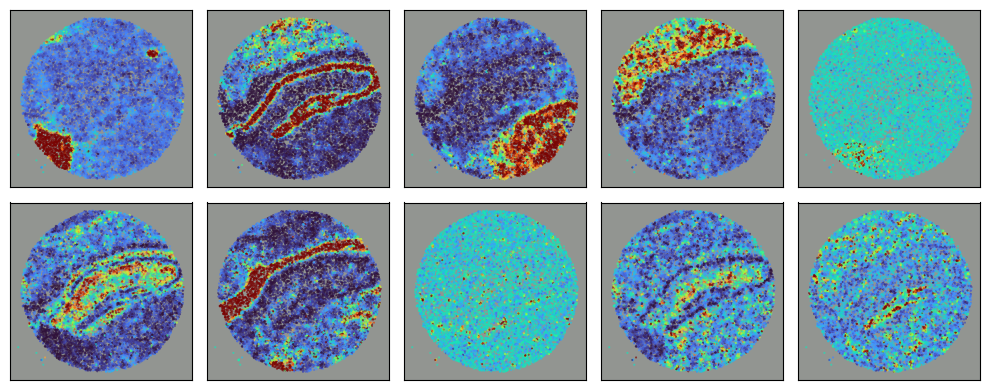

In [36]:
plot_factors(factors1, X, moran_idx=None, size=2, s=0.2)

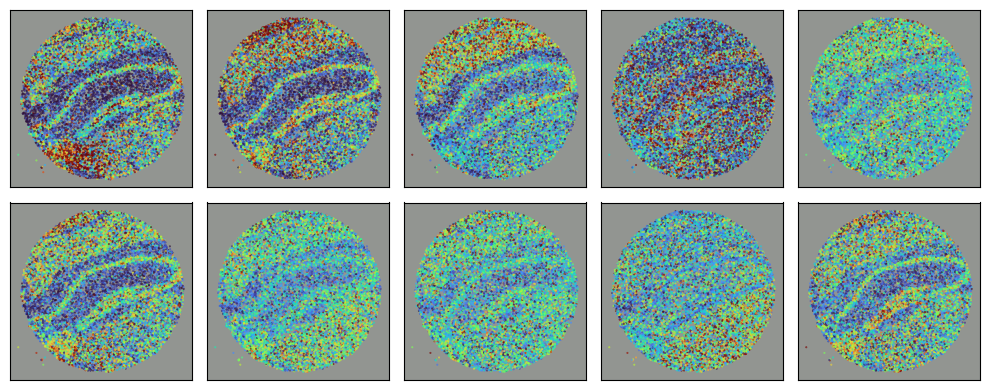

In [37]:
plot_factors(factors2, X, moran_idx=None, size=2, s=0.2)

In [38]:
model.sf.prior.kernel.lengthscale

Parameter containing:
tensor([[[2.0692]],

        [[2.7648]],

        [[2.1631]],

        [[1.7222]],

        [[0.4121]],

        [[2.0864]],

        [[2.7376]],

        [[0.5673]],

        [[1.6305]],

        [[1.0936]]], requires_grad=True)

In [39]:
model.sf.prior.Z

Parameter containing:
tensor([[ 7.2465e+01,  6.5772e+01],
        [-6.0416e+01, -7.9901e-02],
        [ 4.0319e+00,  7.8332e+01],
        ...,
        [ 3.5600e+00,  9.3873e+01],
        [-1.6369e+01, -3.8063e+00],
        [ 6.6647e+01, -5.7617e+00]], requires_grad=True)